<a href="https://colab.research.google.com/github/ragaslan/i-am-learning-pytorch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from ast import increment_lineno
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# convert MNIST image files into a tensor of 4 Dimensions (# of images, height, width, color channel)
transform = transforms.ToTensor()

In [6]:
# train data
train_data = datasets.MNIST(root='/cnn_data',train=True,download=True,transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.8MB/s]


In [7]:
#test data
test_data = datasets.MNIST(root='/cnn_data',train=False,download=True,transform=transform)


In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
# create small batch size for images
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [11]:
# define our CNN model
# describe convolutional layer and what it is doing
# this is just an example
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)

In [12]:
# grab 1 MNIST record/image
for i,(X_Train,y_train) in enumerate(train_data):
  break


In [13]:
X_Train.shape

torch.Size([1, 28, 28])

In [14]:
x = X_Train.view(1,1,28,28)

In [15]:
# perform our first convolution
x = F.relu(conv1(x)) # relu is activation function

In [16]:
# 1 single image, 6 is the filters we asked for, 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [17]:
# pass thru the pooling layer
x = F.max_pool2d(x,2,2) # kernel 2, stride 2
x.shape

torch.Size([1, 6, 13, 13])

In [18]:
# do our second convolutional layer
x = F.relu(conv2(x))

In [19]:
x.shape # again we did not set padding so we lose 2 pixels around the outside of the image

torch.Size([1, 16, 11, 11])

In [20]:
# pooling layer
x = F.max_pool2d(x,2,2)

In [21]:
x.shape # 11 / 2 = 5.5 but we have to round down, because you can not invent data to round up

torch.Size([1, 16, 5, 5])

In [22]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1) # input,output,kernel size, stride
    # fully connected layer
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2

    # second pass

    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2

    # re-view to flatten it out

    X = X.view(-1,16*5*5) # negative one so that we can vary the batch size

    #fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X,dim=1)


In [23]:
# create an instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [24]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) # smaller the learning rate, longer its gonna take to train


In [30]:
import time
start_time = time.time()

# create variables to tracks things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  # train
  for b,(X_train,y_train) in enumerate(train_loader):
    b+= 1 # start our batches at 1

    y_pred = model(X_train) # get predicted values # not flattened
    loss = criterion(y_pred,y_train) # how of are we ?

    predicted = torch.max(y_pred.data,1)[1] # add up the number of correct predictions

    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch
    trn_corr += batch_corr

    # update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print out some results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')
  train_losses.append(loss)
  train_correct.append(trn_corr)

  # test
  with torch.no_grad():
    for b,(X_test,y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1] # adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away

  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total_time = current_time - start_time
print(f'Training took: {total_time/60} minutes !')

Epoch: 0 Batch: 600 Loss: 0.007151054684072733
Epoch: 0 Batch: 1200 Loss: 0.011097034439444542
Epoch: 0 Batch: 1800 Loss: 0.0017998721450567245
Epoch: 0 Batch: 2400 Loss: 0.0001049584461725317
Epoch: 0 Batch: 3000 Loss: 0.0031431831885129213
Epoch: 0 Batch: 3600 Loss: 0.003668801160529256
Epoch: 0 Batch: 4200 Loss: 0.0037249946035444736
Epoch: 0 Batch: 4800 Loss: 0.00015864608576521277
Epoch: 0 Batch: 5400 Loss: 0.0796482041478157
Epoch: 0 Batch: 6000 Loss: 0.0808732658624649
Epoch: 1 Batch: 600 Loss: 0.014099588617682457
Epoch: 1 Batch: 1200 Loss: 0.0382874570786953
Epoch: 1 Batch: 1800 Loss: 0.16302265226840973
Epoch: 1 Batch: 2400 Loss: 0.02186887338757515
Epoch: 1 Batch: 3000 Loss: 0.0024396399967372417
Epoch: 1 Batch: 3600 Loss: 0.0013979513896629214
Epoch: 1 Batch: 4200 Loss: 0.000989563181065023
Epoch: 1 Batch: 4800 Loss: 0.010317974723875523
Epoch: 1 Batch: 5400 Loss: 0.16506639122962952
Epoch: 1 Batch: 6000 Loss: 0.0027098222635686398
Epoch: 2 Batch: 600 Loss: 0.00036099221324

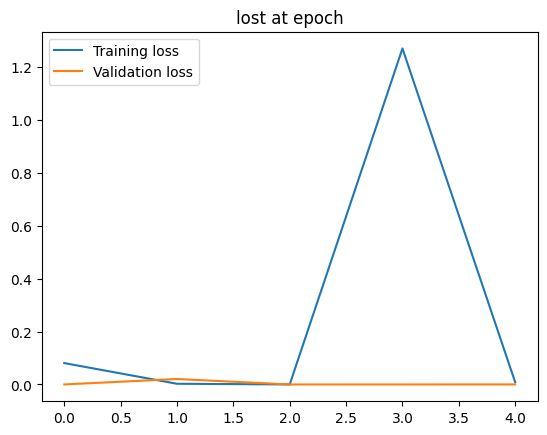

In [31]:
# graph the loss at epoch
training_losses = [tl.item() for tl in train_losses]
plt.plot(training_losses,label="Training loss")
plt.plot(test_losses,label="Validation loss")
plt.title("lost at epoch")
plt.legend()

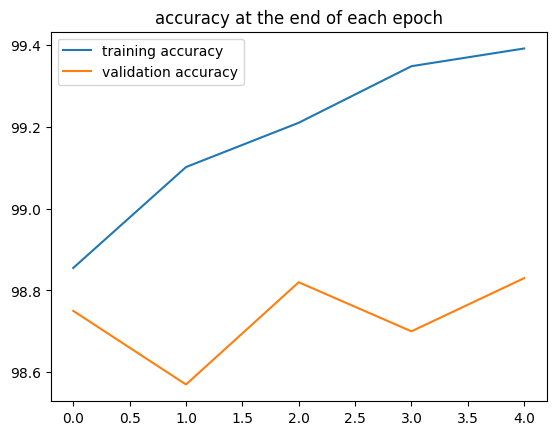

In [32]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct],label='training accuracy')
plt.plot([t/100 for t in test_correct],label='validation accuracy')
plt.title("accuracy at the end of each epoch")
plt.legend()


In [33]:
test_load_everyting = DataLoader(test_data,batch_size=10000,shuffle=False)

In [39]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everyting:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()


In [42]:
# did for correct
# percentage
correct.item() / len(test_data) * 100

98.83

In [44]:
# grab an image
test_data[4132]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.4941, 0.9686, 

In [54]:
# grab just the data
test_data[4142][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [53]:
# reshape

test_data[4142][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

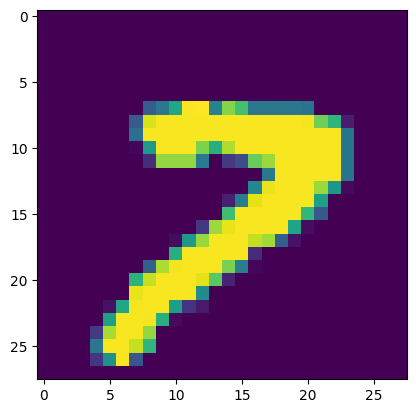

In [52]:
plt.imshow(test_data[4142][0].reshape(28,28))

In [48]:
# pass the image thru our model
model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [55]:
with torch.no_grad():
  new_prediction = model(test_data[4142][0].view(1,1,28,28))


In [56]:
new_prediction

tensor([[-1.8165e+01, -1.2611e+01, -1.2338e+01, -1.2249e+01, -1.1270e+01,
         -1.8185e+01, -2.8992e+01, -3.3497e-05, -1.7742e+01, -1.1710e+01]])

In [58]:
new_prediction.argmax()

tensor(7)